<a href="https://colab.research.google.com/github/Manuja001/DL_Lab_08/blob/main/Gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The agent-environment interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment.

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward obtained by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agent to converge to a near-optimal policy.


## The agent-environment interface

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/agent-environment.png" style="width: 500px;" align="left"/>

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$.


## The environment: Navigation in a gridworld

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. It the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-learning

![title](https://raw.githubusercontent.com/dkasthurirathna/dl/master/q.png)
From Sutton & Barto (1998), Reinforcement Learning.

In [ ]:
import numpy as np
import operator
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline

# Classes for the Enviroment and the Agent

- The GridWorld class contains the environment
- The dimensions of the environment are defined
- Locations of all rewards are stored
- Functions for different methods written
    - `get_available_actions` returns possible actions
    - `agent_on_map` prints out current location of the agent on the grid (used for debugging)
    - `get_reward` returns the reward for an input position
    - `make_step` moves the agent in a specified direction

In [ ]:
class GridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 8
        self.width = 8
        self.grid = np.zeros(( self.height, self.width)) - 1

        # Set random start location for the agent
        self.current_location = ( 4, np.random.randint(0,5))

        # Set locations for the bomb and the gold
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [ self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[ self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']


    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]


    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location
        reward = 0

        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [ ]:
class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [ ]:
class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        #type your code here
        if np.random.rand() < self.epsilon:
            action = np.random.choice(available_actions)
        else:
            state = self.environment.current_location
            q_values = self.q_table[state]

            max_q = max([q_values[a] for a in available_actions])
            best_actions = [a for a in available_actions if q_values[a] == max_q]

            action = np.random.choice(best_actions)
        return action

    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
       #type your code here
        old_q = self.q_table[old_state][action]
        next_max_q = max(self.q_table[new_state].values())

        self.q_table[old_state][action] = old_q + self.alpha * (reward + self.gamma * next_max_q - old_q)

In [ ]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log

    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True

        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log

    return reward_per_episode # Return performance log

## Run Random Agent

- Random agent moves randomly and does not learn from it's actions.
- This gives a base performance to compare the Q-Learning agent to

In [ ]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 2)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = UP
Reward obtained = -1.0
Current position of the agent = (3, 2)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


- Here the random agent is ran for 500 trials
- Performance is obviously inconsistent and not optimal

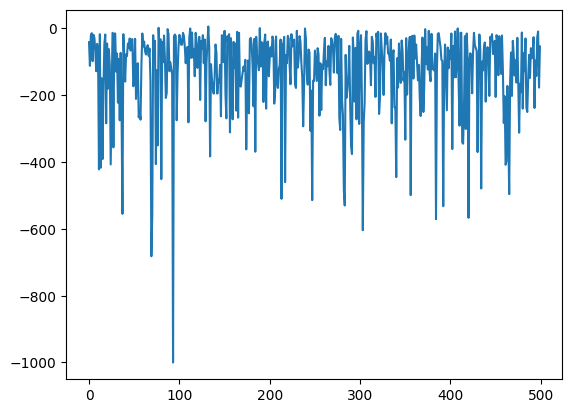

In [ ]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

## Q-Agent

- Here the Q-Learning agent is ran for 500 trials again
- Performance is plotted
- Performance increases greatly

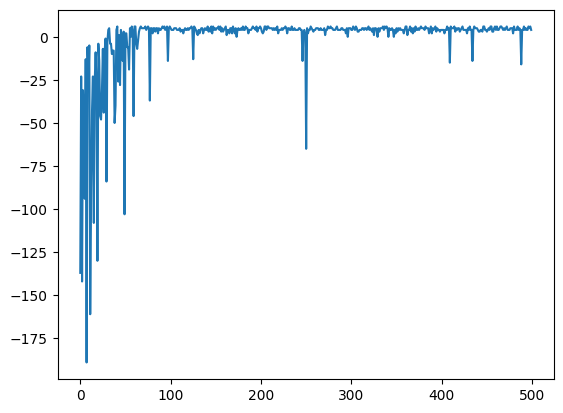

In [ ]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

Print the final Q-value table with nice formatting.

In [ ]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

(0, 0)
	UP
		-0.30000000000000004
	DOWN
		-0.32728
	LEFT
		-0.30000000000000004
	RIGHT
		-0.2341441
(0, 1)
	UP
		-0.2
	DOWN
		-0.11000000000000001
	LEFT
		-0.1
	RIGHT
		5.076898517487066
(0, 2)
	UP
		1.709999992039796
	DOWN
		3.697974681382407
	LEFT
		1.1225124216350777
	RIGHT
		9.999999999999993
(0, 3)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 4)
	UP
		-0.1
	DOWN
		-0.1
	LEFT
		9.01522909781639
	RIGHT
		-0.1174471489
(0, 5)
	UP
		-0.2
	DOWN
		-0.218
	LEFT
		1.9622814397278168
	RIGHT
		-0.21
(0, 6)
	UP
		-0.4
	DOWN
		-0.4199900000000001
	LEFT
		-0.29748154721946496
	RIGHT
		-0.4
(0, 7)
	UP
		-0.4
	DOWN
		-0.40990000000000004
	LEFT
		-0.48100000000000004
	RIGHT
		-0.4
(1, 0)
	UP
		-0.4539000000000001
	DOWN
		-0.5784433310557001
	LEFT
		-0.5
	RIGHT
		-0.45324346257123477
(1, 1)
	UP
		-0.28
	DOWN
		-0.34688478
	LEFT
		-0.30000000000000004
	RIGHT
		3.3238709191125806
(1, 2)
	UP
		8.999999999999986
	DOWN
		2.2544535574321323
	LEFT
		0.2568546025776819
	RIGHT
		-5.217031
(1, 3)
	UP
		0
	DOW

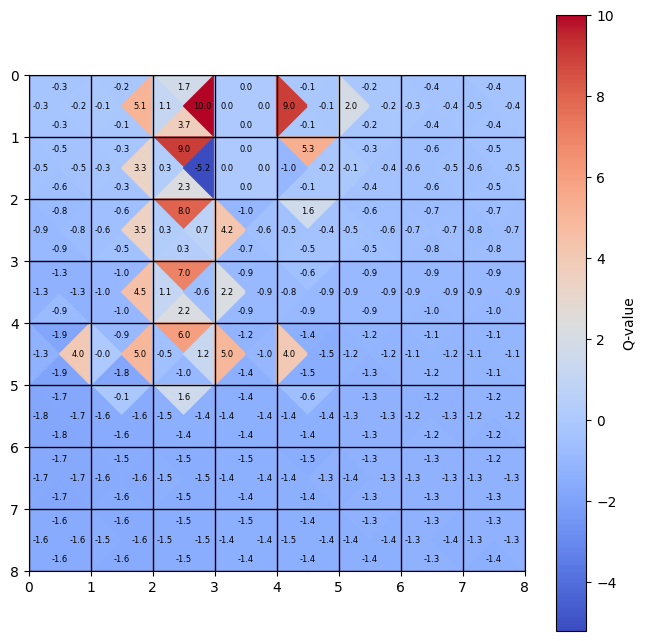

In [ ]:
def plot_q_table(q_table, width, height):
    fig, ax = plt.subplots(figsize=(width, height))
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    ax.set_aspect('equal')
    ax.invert_yaxis()  # so (0,0) is at top-left like gridworlds

    # Normalize Q-values for colormap
    all_q = [q for state in q_table.values() for q in state.values()]
    vmin, vmax = min(all_q), max(all_q)
    norm = plt.Normalize(vmin, vmax)
    cmap = plt.cm.coolwarm

    for (x, y), actions in q_table.items():
        cx, cy = y, x  # swap so width=columns, height=rows

        # Get Q-values
        q_up = actions['UP']
        q_down = actions['DOWN']
        q_left = actions['LEFT']
        q_right = actions['RIGHT']

        # Draw triangles for each action
        # UP
        up_poly = [(cx, cy), (cx+1, cy), (cx+0.5, cy+0.5)]
        ax.add_patch(patches.Polygon(up_poly, color=cmap(norm(q_up))))
        # DOWN
        down_poly = [(cx, cy+1), (cx+1, cy+1), (cx+0.5, cy+0.5)]
        ax.add_patch(patches.Polygon(down_poly, color=cmap(norm(q_down))))
        # LEFT
        left_poly = [(cx, cy), (cx, cy+1), (cx+0.5, cy+0.5)]
        ax.add_patch(patches.Polygon(left_poly, color=cmap(norm(q_left))))
        # RIGHT
        right_poly = [(cx+1, cy), (cx+1, cy+1), (cx+0.5, cy+0.5)]
        ax.add_patch(patches.Polygon(right_poly, color=cmap(norm(q_right))))

        # Optional: annotate values
        ax.text(cx+0.5, cy+0.2, f"{q_up:.1f}", ha='center', va='center', fontsize=6)
        ax.text(cx+0.5, cy+0.8, f"{q_down:.1f}", ha='center', va='center', fontsize=6)
        ax.text(cx+0.2, cy+0.5, f"{q_left:.1f}", ha='center', va='center', fontsize=6)
        ax.text(cx+0.8, cy+0.5, f"{q_right:.1f}", ha='center', va='center', fontsize=6)

    # Add grid lines
    for i in range(width+1):
        ax.axvline(i, color="black", lw=1)
    for j in range(height+1):
        ax.axhline(j, color="black", lw=1)

    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="Q-value")
    plt.show()


# Example usage
plot_q_table(agentQ.q_table, environment.width, environment.height)

In [ ]:
class GridWorldEnvWrapper:
    def __init__(self, gridworld_class_instance=None):
        # create a fresh GridWorld if not supplied
        self.env = GridWorld() if gridworld_class_instance is None else gridworld_class_instance
        self.height = self.env.height
        self.width = self.env.width
        self.n_states = self.height * self.width
        self.actions = self.env.actions
        self.n_actions = len(self.actions)

    def reset(self):
        # resets env to a new random-start like original lab
        self.env = GridWorld()
        return self._state_vec(self.env.current_location)

    def _state_vec(self, location):
        vec = np.zeros(self.n_states, dtype=np.float32)
        idx = location[0]*self.width + location[1]
        vec[idx] = 1.0
        return vec

    def step(self, action_index):
        action = self.actions[action_index]
        reward = self.env.make_step(action)
        new_loc = self.env.current_location
        done = (self.env.check_state() == 'TERMINAL')
        return self._state_vec(new_loc), float(reward), done


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


In [ ]:
class DQNNet(nn.Module):
    def __init__(self, state_size, action_size, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, action_size)
        )
    def forward(self, x):
        return self.net(x)


In [ ]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buf = deque(maxlen=capacity)
    def push(self, s,a,r,s2,done): self.buf.append((s,a,r,s2,done))
    def sample(self, batch_size): return map(np.stack, zip(*random.sample(self.buf, batch_size)))
    def __len__(self): return len(self.buf)


# q agent implimentation
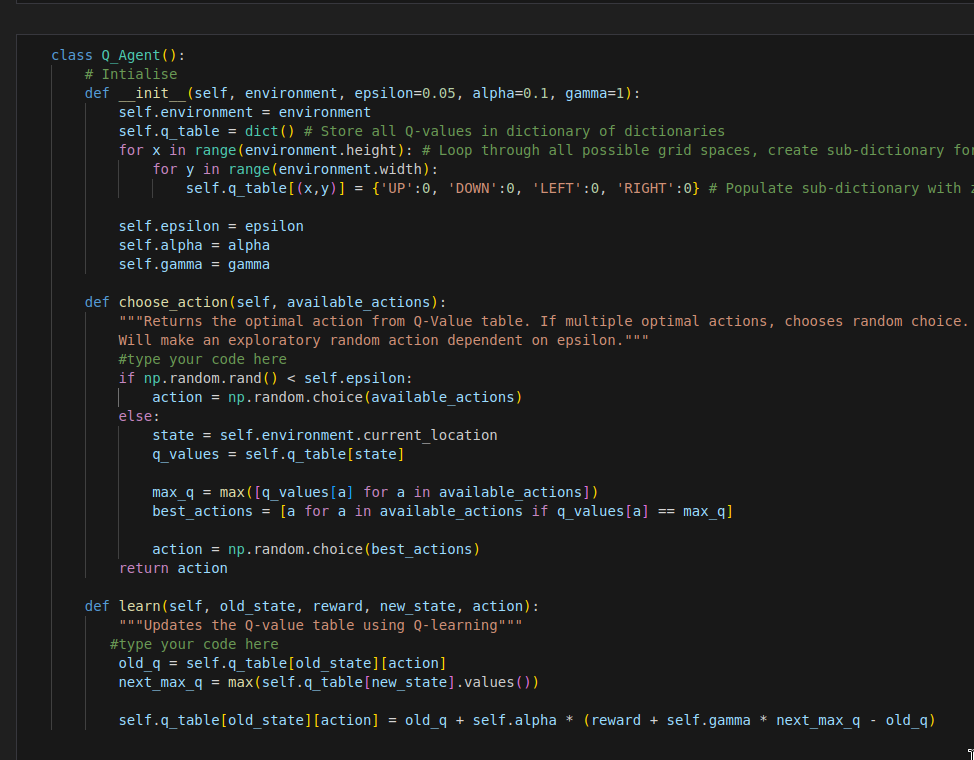


In [ ]:
class GridWorld:
    def __init__(self):
        self.height = 20
        self.width = 20
        self.grid = np.zeros((self.height, self.width)) - 1

        self.current_location = (4, np.random.randint(0,5))
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [self.bomb_location, self.gold_location]

        self.grid[self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[self.gold_location[0], self.gold_location[1]] = 10
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

    def reset(self):
        self.current_location = (4, np.random.randint(0,5))
        return self.current_location

    def get_available_actions(self):
        return self.actions

    def get_reward(self, new_location):
        return self.grid[new_location[0], new_location[1]]

    def make_step(self, action):
        last_location = self.current_location
        if action == 'UP':
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0]-1, self.current_location[1])
                reward = self.get_reward(self.current_location)
        elif action == 'DOWN':
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0]+1, self.current_location[1])
                reward = self.get_reward(self.current_location)
        elif action == 'LEFT':
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0], self.current_location[1]-1)
                reward = self.get_reward(self.current_location)
        elif action == 'RIGHT':
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0], self.current_location[1]+1)
                reward = self.get_reward(self.current_location)
        return reward

    def check_state(self):
        if self.current_location in self.terminal_states:
            return 'TERMINAL'
        return 'NON-TERMINAL'


In [ ]:
class DQNNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(DQNNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)


In [ ]:
def one_hot_state(env, state):
    s = np.zeros(env.height * env.width, dtype=np.float32)
    s[state[0] * env.width + state[1]] = 1.0
    return s

In [ ]:
def train_DQN(env, episodes=300, gamma=0.95, lr=0.001, epsilon=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state_dim = env.height * env.width
    action_dim = len(env.actions)
    model = DQNNet(state_dim, action_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    rewards_per_episode = []

    for ep in range(episodes):
        state = env.reset()
        s_vec = one_hot_state(env, state)
        done = False
        total_reward = 0

        while not done:
            if random.random() < epsilon:
                action = random.choice(range(action_dim))
            else:
                with torch.no_grad():
                    q_vals = model(torch.tensor(s_vec).to(device))
                    action = int(torch.argmax(q_vals).item())

            next_state, reward = None, env.make_step(env.actions[action])
            done = env.check_state() == 'TERMINAL'
            next_vec = one_hot_state(env, env.current_location)

            with torch.no_grad():
                q_next = model(torch.tensor(next_vec, dtype=torch.float32).to(device))
                q_target = torch.tensor([reward], dtype=torch.float32).to(device)
                if not done:
                    q_target += gamma * torch.max(q_next)

            q_pred = model(torch.tensor(s_vec, dtype=torch.float32).to(device))[action]

            # Make sure q_pred is also a single value tensor
            loss = loss_fn(q_pred.unsqueeze(0), q_target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_reward += reward
            s_vec = next_vec

        rewards_per_episode.append(total_reward)
        epsilon = max(0.01, epsilon * 0.995)

        if ep % 50 == 0:
            print(f"Episode {ep}, Total Reward: {total_reward:.2f}")

    return rewards_per_episode

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
env = GridWorld()
epsilons = [0.1, 0.5, 0.9]
results = {}

for eps in epsilons:
    print(f"\nTraining with epsilon = {eps}")
    rewards = train_DQN(env, episodes=300, epsilon=eps)
    results[eps] = rewards


Training with epsilon = 0.1
Episode 0, Total Reward: -500.00
Episode 50, Total Reward: -161.00
Episode 100, Total Reward: 4.00
Episode 150, Total Reward: 3.00
Episode 200, Total Reward: 4.00
Episode 250, Total Reward: 6.00

Training with epsilon = 0.5
Episode 0, Total Reward: -233.00
Episode 50, Total Reward: -12.00
Episode 100, Total Reward: 3.00
Episode 150, Total Reward: 1.00
Episode 200, Total Reward: 5.00
Episode 250, Total Reward: 4.00

Training with epsilon = 0.9
Episode 0, Total Reward: -194.00
Episode 50, Total Reward: -138.00
Episode 100, Total Reward: -15.00
Episode 150, Total Reward: 0.00
Episode 200, Total Reward: 4.00
Episode 250, Total Reward: -2.00


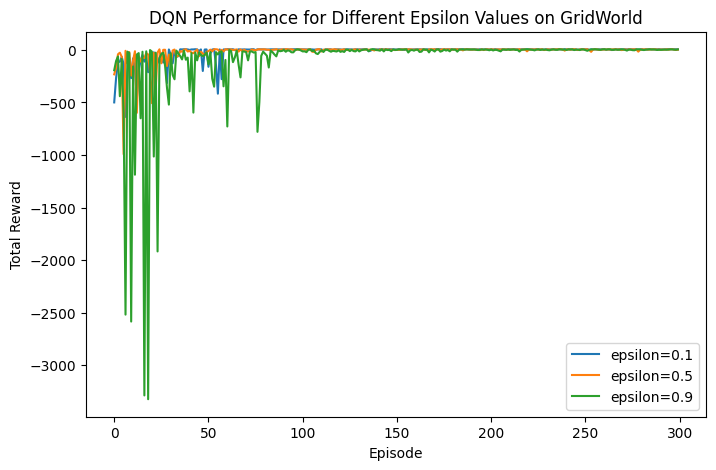

In [ ]:
plt.figure(figsize=(8,5))
for eps, rewards in results.items():
    plt.plot(rewards, label=f"epsilon={eps}")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.title("DQN Performance for Different Epsilon Values on GridWorld")
plt.show()